## Attention source code & LSTM model

In [ ]:
#https://gist.github.com/cbaziotis/7ef97ccf71cbc14366835198c09809d2
#Attention source code
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM,Input,Embedding,Activation,RepeatVector,Permute,concatenate,Layer,TimeDistributed,GRU
from keras import optimizers
def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)),axis=-1)
    else:
        return K.dot(x, kernel)
class AttentionWithContext(Layer):
    """
Attention operation, with a context/query vector, for temporal data.
"Hierarchical Attention Networks for Document Classification"
by using a context vector to assist the attention
# Input shape
    3D tensor with shape: (samples, steps, features).
# Output shape
    2D tensor with shape: (samples, features).
How to use:
Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
The dimensions are inferred based on the output shape of the RNN.
Note: The layer has been tested with Keras 2.0.6
Example:
    model.add(LSTM(64, return_sequences=True))
    model.add(AttentionWithContext())
    # next add a Dense layer (for classification/regression) or whatever
     """
def __init__(self,
             W_regularizer=None, u_regularizer=None, b_regularizer=None,
             W_constraint=None, u_constraint=None, b_constraint=None,
             bias=True, **kwargs):
    self.supports_masking = True
    self.init = initializers.get('glorot_uniform')
    self.W_regularizer = regularizers.get(W_regularizer)
    self.u_regularizer = regularizers.get(u_regularizer)
    self.b_regularizer = regularizers.get(b_regularizer)
    self.W_constraint = constraints.get(W_constraint)
    self.u_constraint = constraints.get(u_constraint)
    self.b_constraint = constraints.get(b_constraint)
    self.bias = bias
    super(AttentionWithContext, self).__init__(**kwargs)
def build(self, input_shape):
    assert len(input_shape) == 3
    self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                             initializer=self.init,
                             name='{}_W'.format(self.name),
                             regularizer=self.W_regularizer,
                             constraint=self.W_constraint)
    if self.bias:
        self.b = self.add_weight((input_shape[-1],),
                                 initializer='zero',
                                 name='{}_b'.format(self.name),
                                 regularizer=self.b_regularizer,
                                 constraint=self.b_constraint)
    self.u = self.add_weight((input_shape[-1],),
                             initializer=self.init,
                             name='{}_u'.format(self.name),
                             regularizer=self.u_regularizer,
                             constraint=self.u_constraint)
    super(AttentionWithContext, self).build(input_shape)
def compute_mask(self, input, input_mask=None):
    # do not pass the mask to the next layers
    return None
def call(self, x, mask=None):
    uit = dot_product(x, self.W)
    if self.bias:
        uit += self.b
    uit = K.tanh(uit)
    ait = dot_product(uit, self.u)
    a = K.exp(ait)
    # apply mask after the exp. will be re-normalized next
    if mask is not None:
        # Cast the mask to floatX to avoid float64 upcasting in theano
        a *= K.cast(mask, K.floatx())
    # in some cases especially in the early stages of training the sum may be almost zero
    # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
    # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
    a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
    a = K.expand_dims(a)
    weighted_input = x * a
    return K.sum(weighted_input, axis=1)
def compute_output_shape(self, input_shape):
    return input_shape[0], input_shape[-1]


from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, Dropout

def lstm():
    model = Sequential()

    model.add(LSTM(64, input_shape=(30, 2), return_sequences=True))
    
    model.add(Dropout(0.5))

    model.add(AttentionWithContext())
    model.add(GRU(64, return_sequences=False))

    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

## LSTM 訓練/測試資料集

In [38]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import pandas as pd 
import numpy as np
from tqdm import tqdm
from keras.utils import np_utils 

def lstm_train_data(stock_codes,normalize_p_f, normalize_p):
    stock_code = str(stock_codes[0])
    dataset_train = pd.read_csv('data/stock/'+stock_code+'.csv')
    dataset_train = dataset_train[:600]

    date_lstm_train = dataset_train['date'].to_numpy().tolist() #date為lstm train時的日期

    x = dataset_train[['close','floating']] # x為股價、30日後的漲跌判斷
    y = dataset_train['close'].to_frame()  # y為股價

    
    x = normalize_p_f.transform(x)
    y = normalize_p.transform(y)
    
    x_train = []
    y_train = []
    for i in range(30,len(dataset_train)):
        x_train.append(x[i-30:i])
        y_train.append(y[i,0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))

    #x = 真實股價、真實三十日後floating
    #y = 真實股價(30日後)
    return x_train, y_train, date_lstm_train, dataset_train


def cnn_test_data(stock_codes,date_lstm_test):

    x_test = []
    y_test = []
    cnn_test_dates = []
    for i in tqdm(stock_codes):
        stock_code = str(i)

        for i in range(0,570):#總共570個檔案
            df = pd.read_csv('data/x/'+stock_code+'_'+str(i)+'_x.csv')
            date = df['date'].T.to_numpy().tolist()
            if date[29] != date_lstm_test[0]:
                continue
            else:
                for j in range(len(date_lstm_test)): #要date_lstm_test[0]~ date_lstm_test[last]的cnn predict floating

                    df = pd.read_csv('data/x/'+stock_code+'_'+str(i+j)+'_x.csv')
                    #date = df['date'].T.to_numpy().tolist()
                    #cnn_test_dates.append(date[0])
                    df = df.drop(['date'], axis = 1)

                    #y = df['y'].T.to_numpy().tolist()
                    #y_test.append(y[0])

                    df = df.drop(['y'], axis = 1)
                    df = df.drop(['floating'], axis = 1)

                    x = df.T.to_numpy().tolist()
                    x_test.append(x)
                break
    x_test = np.array(x_test)
    x_test = x_test.reshape(len(date_lstm_test),20,30,1).astype('float32') 
    x_test = (x_test+1)/2

    return x_test 


def cnn_predict(date_lstm_test):
    cnn = load_model('cnn1.h5')
    cnn_x_test = cnn_test_data([1101], date_lstm_test)

    #cnn_predict_floating = date_lstm_test這些日子的cnn 預測floating
    cnn_predict_floating = cnn.predict_classes(cnn_x_test).astype('float32')
    cnn_predict_floating = pd.DataFrame(cnn_predict_floating)
    cnn_predict_floating.reset_index(drop = True, inplace = True)

    return cnn_predict_floating

def stock_normalize(stock_codes):
    stock_code = str(stock_codes[0])
    df = pd.read_csv('data/stock/'+stock_code+'.csv')
    p_f = df[['close','floating']]
    p = df['close'].to_frame()
    f = df['floating'].to_frame()
    normalize_p_f = MinMaxScaler(feature_range = (0, 1)).fit(p_f)
    normalize_p = MinMaxScaler(feature_range = (0, 1)).fit(p)
    normalize_f = MinMaxScaler(feature_range = (0, 1)).fit(f)
    return normalize_p_f, normalize_p, normalize_f

def lstm_test_data(stock_codes, dataset_train ,normalize_p, normalize_f):
    x_test = []
    real_stock_price= []

    stock_code = str(stock_codes[0])
    df = pd.read_csv('data/stock/'+stock_code+'.csv')
    dataset_train = df[:600]
    dataset_test = df[600:len(df)-1]
    date_lstm_test = df[600-30:len(df)-1]['date'].to_numpy().tolist()
    days = len(dataset_test)
    
    #預測的答案
    real_stock_price = dataset_test['close'].to_frame().values

    #test的股價
    dataset_total = pd.concat((dataset_train['close'].to_frame(), dataset_test['close'].to_frame()), axis = 0)
    inputs_close = dataset_total[len(dataset_total) - len(dataset_test) - 30:].values
    inputs_close = normalize_p.transform(inputs_close)
    
    #print(len(inputs_close)) #136
    #print(len(date_lstm_test)) #136

    inputs_floating_total = pd.concat((dataset_train['floating'].to_frame(), dataset_test['floating'].to_frame()), axis = 0)
    inputs_floating = inputs_floating_total[len(inputs_floating_total) - len(dataset_test) - 30:].values
    inputs_floating = normalize_f.transform(inputs_floating)
    #print(len(inputs_floating))  #136
    
    cnn_predict_floating = cnn_predict(date_lstm_test).values -1  #date_lstm_test這些日子的cnn predict
    cnn_predict_floating = normalize_f.transform(cnn_predict_floating)  
    #print(len(dataset_test))#106
    
    X_test = []
    for i in range(30, len(dataset_test)+30):
        floating = pd.concat([pd.DataFrame(inputs_floating[i-30]),pd.DataFrame(cnn_predict_floating[i-29:i])]) #第一筆正確 其他預測
        #floating = pd.concat([pd.DataFrame(inputs_floating[0:29]),pd.DataFrame(cnn_predict_floating[i])]) #第一筆正確 其他預測
        floating.reset_index(drop = True, inplace = True)

        inputs = pd.concat([pd.DataFrame(inputs_close[i-30:i]),floating],axis=1)
        inputs.reset_index(drop = True, inplace = True)
        inputs = inputs.values
        X_test.append(inputs)
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2)) 

    return X_test, real_stock_price,date_lstm_test
                            
    
stock = [1102]
normalize_p_f, normalize_p, normalize_f = stock_normalize(stock)
x_train, y_train, date_lstm_train, dataset_train = lstm_train_data(stock,normalize_p_f, normalize_p)
x_test, real_stock_price, date_lstm_test = lstm_test_data(stock, dataset_train, normalize_p, normalize_f)

100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


In [39]:
mlstm = lstm()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 30, 64)            17152     
_________________________________________________________________
dropout_10 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
attention_with_context_10 (A (None, 30, 64)            0         
_________________________________________________________________
gru_8 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 41,985
Trainable params: 41,985
Non-trainable params: 0
_________________________________________________________________


In [10]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=10)
mlstm.fit(x_train, y_train, epochs = 128, batch_size = 64,verbose=2)

Epoch 1/128
 - 1s - loss: 0.0190
Epoch 2/128
 - 0s - loss: 0.0059
Epoch 3/128
 - 0s - loss: 0.0038
Epoch 4/128
 - 0s - loss: 0.0028
Epoch 5/128
 - 0s - loss: 0.0022
Epoch 6/128
 - 0s - loss: 0.0018
Epoch 7/128
 - 0s - loss: 0.0014
Epoch 8/128
 - 0s - loss: 0.0015
Epoch 9/128
 - 0s - loss: 0.0014
Epoch 10/128
 - 0s - loss: 0.0014
Epoch 11/128
 - 0s - loss: 0.0012
Epoch 12/128
 - 0s - loss: 0.0012
Epoch 13/128
 - 0s - loss: 0.0013
Epoch 14/128
 - 0s - loss: 0.0011
Epoch 15/128
 - 0s - loss: 0.0012
Epoch 16/128
 - 0s - loss: 0.0010
Epoch 17/128
 - 0s - loss: 0.0011
Epoch 18/128
 - 0s - loss: 9.9823e-04
Epoch 19/128
 - 0s - loss: 8.5355e-04
Epoch 20/128
 - 0s - loss: 9.5018e-04
Epoch 21/128
 - 0s - loss: 9.3964e-04
Epoch 22/128
 - 0s - loss: 9.7241e-04
Epoch 23/128
 - 0s - loss: 8.6125e-04
Epoch 24/128
 - 0s - loss: 0.0010
Epoch 25/128
 - 0s - loss: 8.5948e-04
Epoch 26/128
 - 0s - loss: 9.1588e-04
Epoch 27/128
 - 0s - loss: 9.4191e-04
Epoch 28/128
 - 0s - loss: 8.6415e-04
Epoch 29/128
 - 0

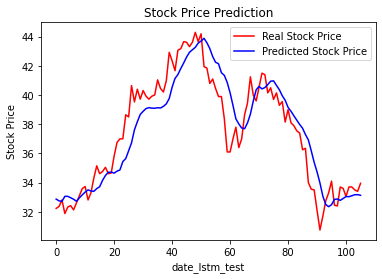

In [11]:
import matplotlib.pyplot as plt 
from keras import models

predicted_stock_price = mlstm.predict(x_test)
predicted_stock_price = normalize_p.inverse_transform(predicted_stock_price) 

plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')  # 紅線表示真實股價
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')  # 藍線表示預測股價
plt.title('Stock Price Prediction')
plt.xlabel('date_lstm_test')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error
print('MSE：',mean_squared_error(real_stock_price,predicted_stock_price))
mape = np.mean(np.abs((real_stock_price - predicted_stock_price) / real_stock_price)) * 100
print('mape:', mape)

MSE： 2.3398306653071628
r squared: 0.8289988632928799
mape: 3.2205769223085947


In [7]:
def dc(r,p):
    total = 0
    for i in range(1,len(r)):
        if (r[i-1]-r[i])*(p[i-1]-p[i]) >= 0:
            tmp = 1
        else:
            tmp = 0
        total += tmp
    result = total/(len(r)-1)*100
    return result

a = dc(real_stock_price,predicted_stock_price)
print(a)
#print(real_stock_price)
#print('==========')
#print(predicted_stock_price)

48.57142857142857
